# CONSIGNA

Aprendizaje Profundo  
Trabajo Práctico Evaluativo N 1 - Constancio Malena  
Objetivo:  
Desarrollar un modelo de clasificación de dígitos manuscritos utilizando el conjunto de datos MNIST y permitir que los alumnos prueben el modelo con imágenes de dígitos creadas por ellos mismos.  
Descripción:  
1.	Entrenar un modelo de red neuronal en el conjunto de datos MNIST.  
2.	Preprocesar imágenes nuevas creadas por los alumnos. Para este apartado los alumnos deberán crear un dataset de 3 a 5 imágenes propias de dígitos manuscritos los cuales utilizaran para predecir con el modelo entrenado.  
3.	Deben mostrar cada predicción y el porcentaje de acierto para cada imagen.  
  
Pasos Sugeridos:
1. Importar Librerías y Cargar el Conjunto de Datos MNIST
2. Preprocesamiento de Datos
3. Construcción y Entrenamiento del Modelo
4. Evaluación del Modelo
5. Preprocesamiento de Imágenes Nuevas
6. Predicción con el Modelo Entrenado

# IMPORTS

In [90]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
import seaborn as sns
from PIL import Image

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#from skimage import transform, filters
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report,confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold

# CLASES AUXILIARES

In [55]:
class EDA_Imagen:
    
    def __init__(self):
        pass
    
    def tamanios(self,lista):
      tamanio = []
      alto_total = 0
      ancho_total = 0
      for i, imagen in enumerate(lista):
        if i < 10:
         tamanio.append(imagen.shape[:2])
      print(f'El tamaño de las primeras 10 imagenes es:{tamanio}')
    
      for alto, ancho in tamanio:
        i+=1
        alto_total = alto + alto_total
        ancho_total = ancho + ancho_total
      alto_total = alto_total // i
      ancho_total = ancho_total // i
      print(f'El tamaño promedio de las imagenes es: alto:{alto_total}, ancho:{ancho_total}')
    
    def escalado (self,lista_imagenes, alto, ancho,interpolado):
      if interpolado == 1:
          inter = cv2.INTER_AREA
      elif interpolado == 2:
          inter = cv2.INTER_CUBIC
      else:
          inter = cv2.INTER_LINEAR
    
      dimensionada = []
    
      for imagen in lista_imagenes:
          dimensionada.append(cv2.resize(imagen,(alto,ancho),interpolation=inter))
      return dimensionada
    
    
    def ecualizador(self,lista,color):
      ecualizado = []
    
      if color == 1:
        for imagen_color in lista:
          canal_b, canal_g, canal_r = cv2.split(imagen_color)
          canal_b_ecualizado = cv2.equalizeHist(canal_b)
          canal_g_ecualizado = cv2.equalizeHist(canal_g)
          canal_r_ecualizado = cv2.equalizeHist(canal_r)
          ecualizado.append( cv2.merge((canal_b_ecualizado, canal_g_ecualizado, canal_r_ecualizado)))
      else:
        for imagen_gris in lista:
          ecualizado.append(cv2.equalizeHist(imagen_gris))
    
      return ecualizado
    
    def nom_brillo(self,lista, color):    
      brillo_normalizado = []
        
      if color == 1:
        brillos = []
        for imagen in lista:
            brillo_promedio = sum(cv2.mean(imagen)[:3]) / 3
            brillos.append(brillo_promedio)
        mean_valor = (max(brillos) / min(brillos))
    
        for imagen in lista:
          brillo_normalizado.append(cv2.convertScaleAbs(imagen, alpha=mean_valor, beta=0))
    
      else:
        brillos = []
        for imagen in lista:
          brillos.append(cv2.mean(imagen)[0])
          suma_valores = sum(brillos)
          cant_valores = len(brillos)
          mean_valor = suma_valores / cant_valores
    
          for imagen in lista:
            brillo_normalizado.append(cv2.convertScaleAbs(imagen, alpha=mean_valor, beta=0))
              
      return brillo_normalizado
    
    def contraste_normal(self, lista, color, factor_contraste):
    
      contraste_normalizado = []
    
      if color == 1:
        for imagen_tratar in lista:
          contraste_normalizado.append(cv2.convertScaleAbs(imagen_tratar, alpha=factor_contraste, beta=0))
    
      else:
        for imagen_tratar in lista:
          imagen_ajustada = np.clip(imagen_tratar * factor_contraste, 0, 255).astype(np.uint8)
          contraste_normalizado.append(imagen_ajustada)
            
      return contraste_normalizado
    
    def saturacion_normal(self, lista, factor_saturacion):
    
      saturacion_normalizado = []
      for imagen_tratar in lista:
            imagen_hsv = cv2.cvtColor(imagen_tratar, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(imagen_hsv)
            s_new = np.clip(s * factor_saturacion, 0, 255).astype(np.uint8)
            imagen_saturada = cv2.merge((h, s_new, v))
            imagen_saturada_rgb = cv2.cvtColor(imagen_saturada, cv2.COLOR_HSV2RGB)
            imagen_saturada_rgb = cv2.cvtColor(imagen_saturada_rgb, cv2.COLOR_BGR2RGB)
            saturacion_normalizado.append(imagen_saturada_rgb)
          
      return saturacion_normalizado
    
    def aliasing_normal(self,lista, factor_aumento, sigma, color):
        aliasin_normal = []
        for imagen in lista:
            superresized_image = transform.rescale(imagen, factor_aumento, anti_aliasing=True)
            smoothed_image = filters.gaussian(superresized_image, sigma=sigma)
            reduced_aliasing_image = transform.rescale(smoothed_image, 1/factor_aumento, anti_aliasing=True)
        
            if color == 1:
               imagen64f_normalizada = cv2.normalize(reduced_aliasing_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
               escalada = cv2.convertScaleAbs(imagen64f_normalizada, alpha=(255.0/1.0))
               aliasin_normal.append(cv2.cvtColor(escalada, cv2.COLOR_RGB2BGR))
            else:
               aliasin_normal.append(reduced_aliasing_image)
        
        return aliasin_normal
    
    def histogramas (self,lista_imagenes, cant_imagenes):
      if len(lista_imagenes) > 2:  # Si la imagen es a color
        imagenes_gris = []
        for imagen in lista_imagenes:
          imagenes_gris.append( cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY))
      else:
        imagenes_gris  = lista_imagenes
    
      histogramas = []
      for imagen in imagenes_gris:
        histogramas.append(cv2.calcHist([imagen], [0], None, [256], [0, 256]))
    
      fig, axes = plt.subplots(1, cant_imagenes, figsize=(12, 3))  # 4 subplots, tamaño 12x3, espacio entre subplots
      for i in range(cant_imagenes):
            if i < len(histogramas):  # Verificar si hay histograma disponible para mostrar
                hist = histogramas[i]
                axes[i].hist(hist, color='red',bins=1024 ,edgecolor='black', linewidth=0.3)
                axes[i].set_xlim(0, 50)
                axes[i].set_ylim(0, 50)  # Ajustar el rango del eje Y al valor máximo del histograma
            else:
                axes[i].axis('off')  # Ocultar el subplot si no hay histograma disponible    
      fig.tight_layout()
        
      plt.show()
    
    def visualizar(self,lista_imagenes):
      num_images = len(lista_imagenes)
      num_rows = (num_images + 3) // 4  # Número de filas (redondeado hacia arriba)
    
      fig, axes = plt.subplots(num_rows, 4, figsize=(10, 10))  # Tamaño de la figura 10x10
    
      for i, ax in enumerate(axes.flat):
          if i < num_images:
              ax.imshow(cv2.cvtColor(lista_imagenes[i], cv2.COLOR_BGR2RGB))
              ax.axis('off')
          else:
              ax.axis('off')  # Ocultar subplots adicionales si no hay imágenes
    
      plt.show()

    def normalizar_imagenes(self, lista_imagenes):
        return [imagen.astype('float32') / 255.0 for imagen in lista_imagenes]
    
    def invertir_colores(self, lista):
        invertidas = []
        for imagen in lista:
            invertidas.append(255 - imagen)
            
        return invertidas
    
    def deteccion_bordes(self, lista, threshold1=100, threshold2=200):
        bordes = []
        for imagen in lista:
            imagen_uint8 = cv2.convertScaleAbs(imagen)
            bordes.append(cv2.Canny(imagen, threshold1, threshold2))
            
        return bordes
    
    def cargar_imagen(self, img_path, color_mode='grayscale'):
        img = load_img(img_path, color_mode=color_mode, target_size=(28, 28))
        img_array = img_to_array(img)
        
        return img_array
    
    def preprocesar_imagen_mnist(self, img_path):
        img = self.cargar_imagen(img_path)
        img = self.invertir_colores([img])[0]
        img = img.astype('float32') / 255.0
        img = np.reshape(img, (28, 28,1))
        
        return img

    def plot_class_distribution(self, labels, title):
        unique, counts = np.unique(labels, return_counts=True)
        colors = viridis(np.linspace(0, 1, len(unique))) 
        plt.bar(unique, counts, tick_label=unique, color=colors)
        plt.title(title)
        plt.xlabel('Clase')
        plt.ylabel('Frecuencia')
        
        for i, count in enumerate(counts):
            plt.text(unique[i], count, str(count), ha='center', va='bottom')
        
        plt.show()

    def display_images(self,images, labels, title):
        plt.figure(figsize=(10, 5))
        for i in range(len(images)):
            img = Image.fromarray(images[i])
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Label: {labels[i]}')
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

# OBTENCIÓN DEL DATASET Y PREPROCESAMIENTO

In [56]:
eda_imagen = EDA_Imagen()

MNIST proporciona tanto datos de entrenamiento como de prueba en conjuntos separados. Los datos de entrenamiento consisten en 60,000 imágenes de dígitos escritos a mano, mientras que los datos de prueba consisten en 10,000 imágenes adicionales. Se obtienen dos tuplas: una para los datos de entrenamiento y otra para los datos de prueba. Cada una de estas tuplas contiene dos arrays: uno para las imágenes y otro para las etiquetas correspondientes.

In [57]:
(x_train_raw, y_train), (x_test_raw, y_test) = mnist.load_data() 

In [58]:
print("Forma de x_train:", x_train_raw.shape)  
print("Forma de y_train:", y_train.shape) 
print("Forma de x_test:", x_test_raw.shape)   
print("Forma de y_test:", y_test.shape)  

Forma de x_train: (60000, 28, 28)
Forma de y_train: (60000,)
Forma de x_test: (10000, 28, 28)
Forma de y_test: (10000,)


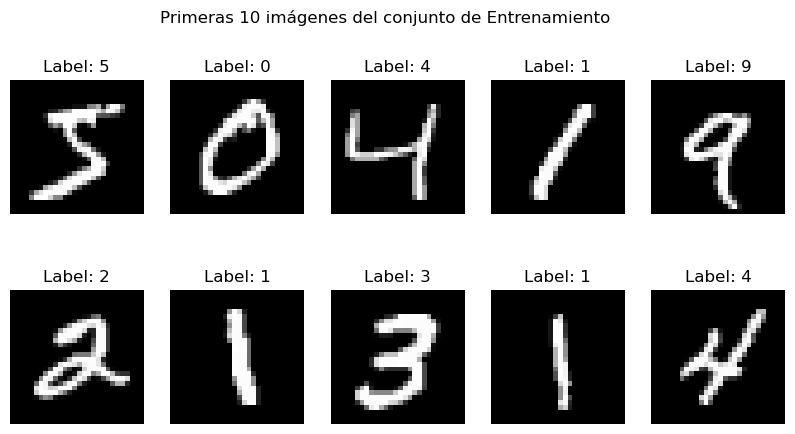

In [59]:
eda_imagen.display_images(x_train_raw[:10], y_train[:10], 'Primeras 10 imágenes del conjunto de Entrenamiento')

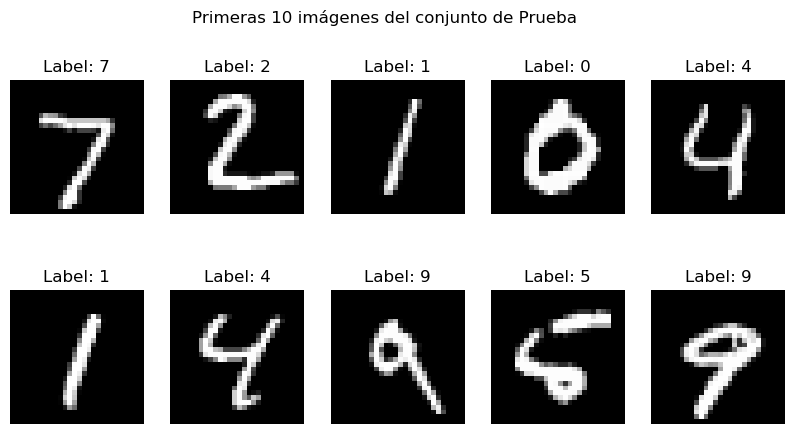

In [60]:
eda_imagen.display_images(x_test_raw[:10], y_test[:10], 'Primeras 10 imágenes del conjunto de Prueba')

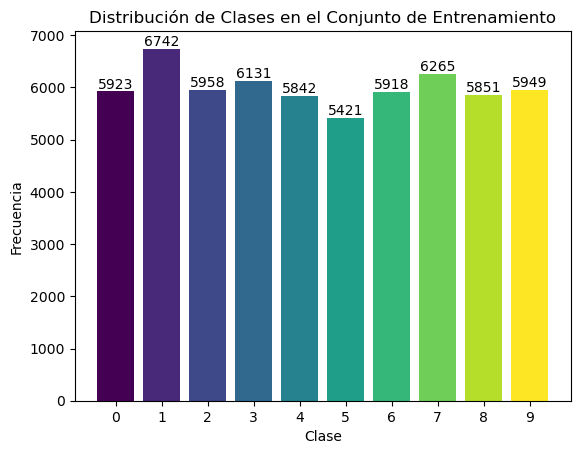

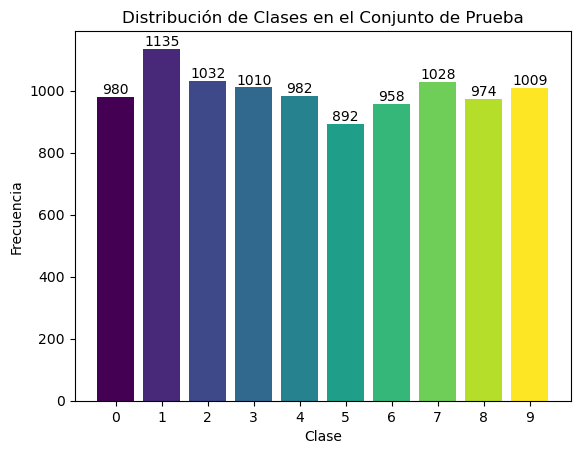

In [61]:
eda_imagen.plot_class_distribution(y_train, 'Distribución de Clases en el Conjunto de Entrenamiento')
eda_imagen.plot_class_distribution(y_test, 'Distribución de Clases en el Conjunto de Prueba')

In [62]:
eda_imagen.tamanios(x_train_raw)

El tamaño de las primeras 10 imagenes es:[(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
El tamaño promedio de las imagenes es: alto:0, ancho:0


In [63]:
eda_imagen.tamanios(x_test_raw)

El tamaño de las primeras 10 imagenes es:[(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
El tamaño promedio de las imagenes es: alto:0, ancho:0


In [64]:
x_train_preprocessed = eda_imagen.contraste_normal(x_train_raw,0,1.5) 
x_test_preprocessed = eda_imagen.contraste_normal(x_test_raw,0,1.5) 

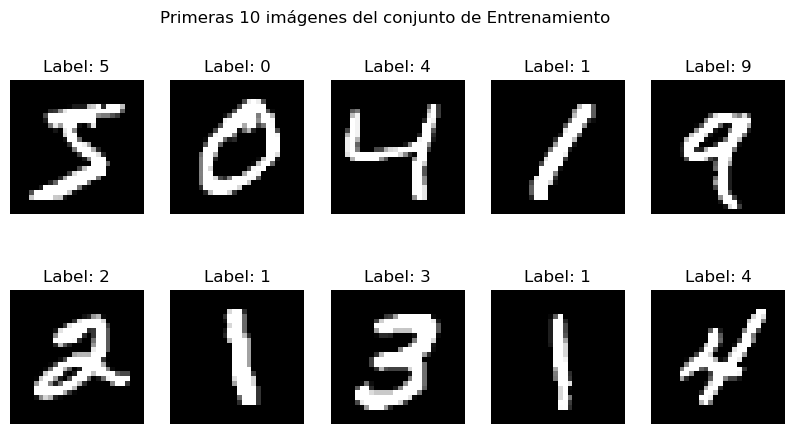

In [65]:
eda_imagen.display_images(x_train_preprocessed[:10], y_train[:10], 'Primeras 10 imágenes del conjunto de Entrenamiento')

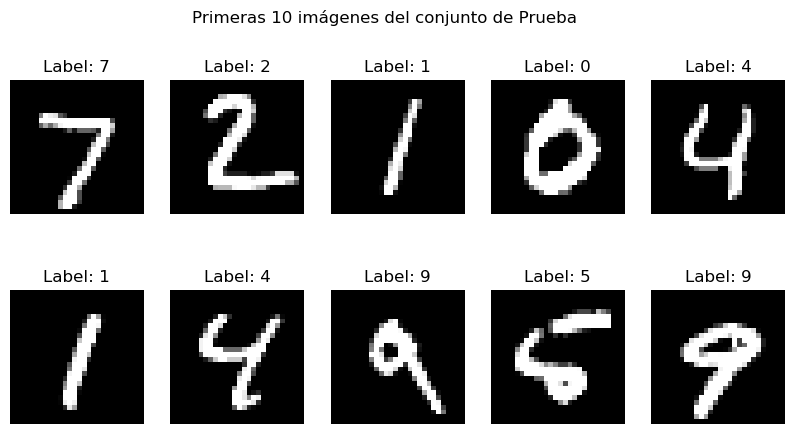

In [66]:
eda_imagen.display_images(x_test_preprocessed[:10], y_test[:10], 'Primeras 10 imágenes del conjunto de Prueba')

In [67]:
#Normalizo las imagenes y las etiquetas: 
x_train_normalized = eda_imagen.normalizar_imagenes(x_train_preprocessed)
y_train_encoded = to_categorical(y_train, 10)

x_test_normalized = eda_imagen.normalizar_imagenes(x_test_preprocessed)
y_test_encoded = to_categorical(y_test, 10)

#Decido aplicar validación cruzada para entrenar el modelo de manera mas robusta
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

# CONSTRUCCIÓN Y ENTRENAMIENTO DEL MODELO

In [68]:
x_train_normalized = np.expand_dims(x_train_normalized, axis=-1)
x_test_normalized = np.expand_dims(x_test_normalized, axis=-1)

In [69]:
def preprocess_data(x):
    x = x.astype('float32') / 255.0
    return np.expand_dims(x, axis=-1)

In [70]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(x_train_normalized)

In [111]:
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = Sequential([
        InputLayer(input_shape=(28, 28, 1)),  
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),  
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),  
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),  
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [112]:
#model = KerasClassifier(build_fn=create_model, verbose=1)
model =  KerasClassifier(build_fn=create_model, verbose=1, validation_split=0.1)

In [113]:
param_grid = {
    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 20],
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.3, 0.5]
}

In [114]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [115]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=kfold, n_jobs=1, verbose=3)  

In [116]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
]

In [117]:
grid_result = grid.fit(x_train_normalized, y_train_encoded, callbacks=callbacks)
print(f"Mejores métricas: {grid_result.best_score_} usando {grid_result.best_params_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/10
2250/2250 [==============================] - 10s 4ms/step - loss: 0.4118 - accuracy: 0.8761 - val_loss: 0.1676 - val_accuracy: 0.9457
Epoch 2/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.3693 - accuracy: 0.8975 - val_loss: 0.1408 - val_accuracy: 0.9615
Epoch 3/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.3555 - accuracy: 0.9015 - val_loss: 0.1150 - val_accuracy: 0.9672
Epoch 4/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.3483 - accuracy: 0.9041 - val_loss: 0.1085 - val_accuracy: 0.9700
Epoch 5/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.3518 - accuracy: 0.9072 - val_loss: 0.1169 - val_accuracy: 0.9647
Epoch 6/10
2250/2250 [==============================] - 9s 4ms/step - loss: 0.3469 - accuracy: 0.9091 - val_loss: 0.1370 - val_accuracy: 0.9635
Epoch 7/10
2250/2250 [==============================] - 9s 4ms/step - loss

# EVALUACIÓN DEL MODELO

In [120]:
x_test_normalized = eda_imagen.normalizar_imagenes(x_test_preprocessed)

In [122]:
x_test_normalized = np.expand_dims(x_test_normalized, axis=-1)

In [123]:
x_test_normalized.shape

(10000, 28, 28, 1)

In [124]:
best_model = grid_result.best_estimator_.model
test_loss, test_acc = best_model.evaluate(x_test_normalized, y_test_encoded)
print(f"Test accuracy: {test_acc}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0211 - accuracy: 0.9931
Test accuracy: 0.9930999875068665


In [125]:
y_pred = best_model.predict(x_test_normalized)
y_pred_classes = np.argmax(y_pred, axis=1) # Calcula las etiquetas predichas (la clase con la probabilidad más alta)

Reporte:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



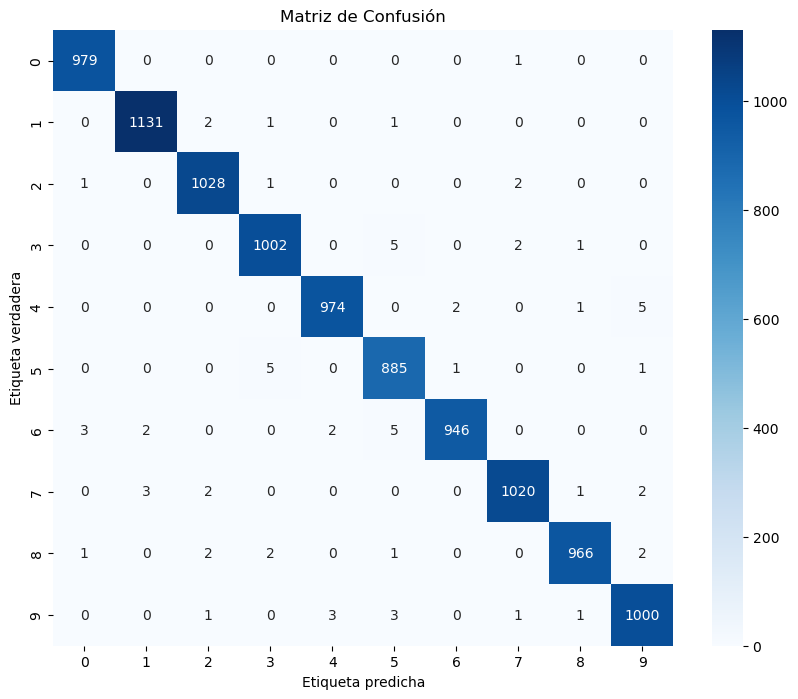

In [130]:
print("Reporte:")
print(classification_report(y_test, y_pred_classes))

conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

In [173]:
best_model.save('best_mnist_model.h5')

# PREPROCESAMIENTO DE IMÁGENES NUEVAS

In [174]:
import os

# Ruta de la carpeta que contiene las imágenes
folder_path = r'C:\Users\-MSI-\Desktop\UGR\3_Cuatrimestre\Aprendizaje_Profundo\nums'

# Obtener la lista de nombres de archivo en la carpeta
image_files = os.listdir(folder_path)

In [175]:
image_files

['0.jpeg',
 '1.jpeg',
 '5.jpeg',
 '6.jpeg',
 '7.jpeg',
 '8.jpeg',
 '9.jpeg',
 'cero.jpeg',
 'cinco.jpeg',
 'dos.jpeg',
 'four.jpeg',
 'ii.jpeg',
 'iii.jpeg',
 'iiii.jpeg',
 'ocho.jpeg',
 'three.jpeg',
 'tres.jpeg',
 'tri.jpeg']

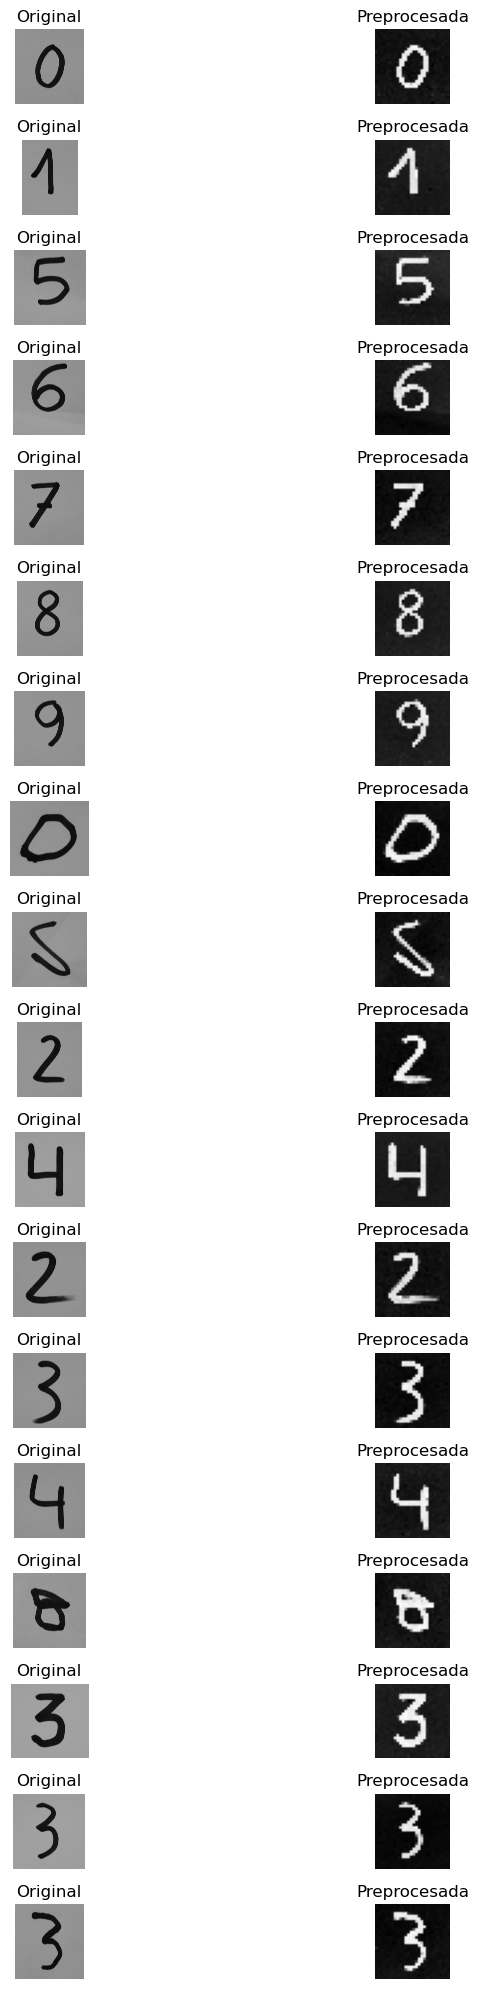

In [176]:
# Lista para almacenar las representaciones preprocesadas de las imágenes
preprocessed_images = []

# Preprocesar las imágenes y almacenarlas en la lista
for img_filename in image_files:
    img_path = os.path.join(folder_path, img_filename)  # Obtener la ruta completa de la imagen      
    preprocessed_img = eda_imagen.preprocesar_imagen_mnist(img_path)  # Preprocesar la imagen
    preprocessed_images.append(preprocessed_img)

# Mostrar las imágenes antes y después del preprocesamiento
fig, axes = plt.subplots(nrows=len(image_files), ncols=2, figsize=(10, 20))

for i, (img_filename, img_prep) in enumerate(zip(image_files, preprocessed_images)):
    # Mostrar la imagen original
    img_original = cv2.imread(os.path.join(folder_path, img_filename), cv2.IMREAD_GRAYSCALE)  # Leer la imagen original
    axes[i, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # Mostrar la imagen preprocesada
    axes[i, 1].imshow(np.squeeze(img_prep), cmap='gray')
    axes[i, 1].set_title('Preprocesada')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [177]:
eda_imagen.tamanios(preprocessed_images)

El tamaño de las primeras 10 imagenes es:[(28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28), (28, 28)]
El tamaño promedio de las imagenes es: alto:10, ancho:10


In [178]:
preprocessed_images_contraste = eda_imagen.contraste_normal(preprocessed_images,0,1.5) 

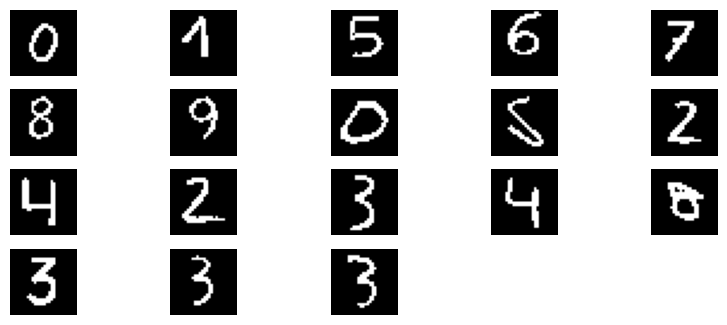

In [180]:
plt.figure(figsize=(10, 5))
for i in range(18):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.squeeze(preprocessed_images_contraste[i]), cmap='gray')
    plt.axis('off')
plt.show()

In [181]:
preprocessed_images_normalized = eda_imagen.normalizar_imagenes(preprocessed_images_contraste)

In [182]:
preprocessed_images_normalized[0].shape

(28, 28, 1)

In [183]:
true_labels = [0, 1, 5, 6, 7, 8, 9, 0, 5, 2, 4, 2, 3, 4, 8, 3, 3, 3]

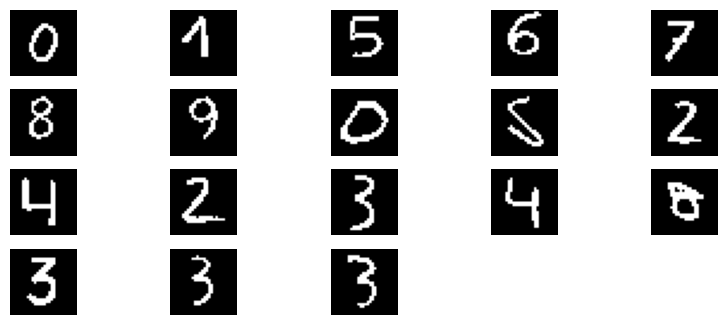

In [184]:
plt.figure(figsize=(10, 5))
for i in range(18):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.squeeze(preprocessed_images_normalized[i]), cmap='gray') 
    plt.axis('off')
plt.show()

# PREDICCIÓN CON EL MODELO ENTRENADO

In [185]:
model = load_model('best_mnist_model.h5')

In [186]:
# Convertir la lista a un array numpy
preprocessed_images = np.array(preprocessed_images)
preprocessed_images = preprocessed_images.reshape(len(preprocessed_images), 28, 28, 1)

predictions = model.predict(preprocessed_images)
predicted_classes = np.argmax(predictions, axis=1)

Reporte:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1

    accuracy                           0.94        18
   macro avg       0.97      0.95      0.95        18
weighted avg       0.96      0.94      0.94        18



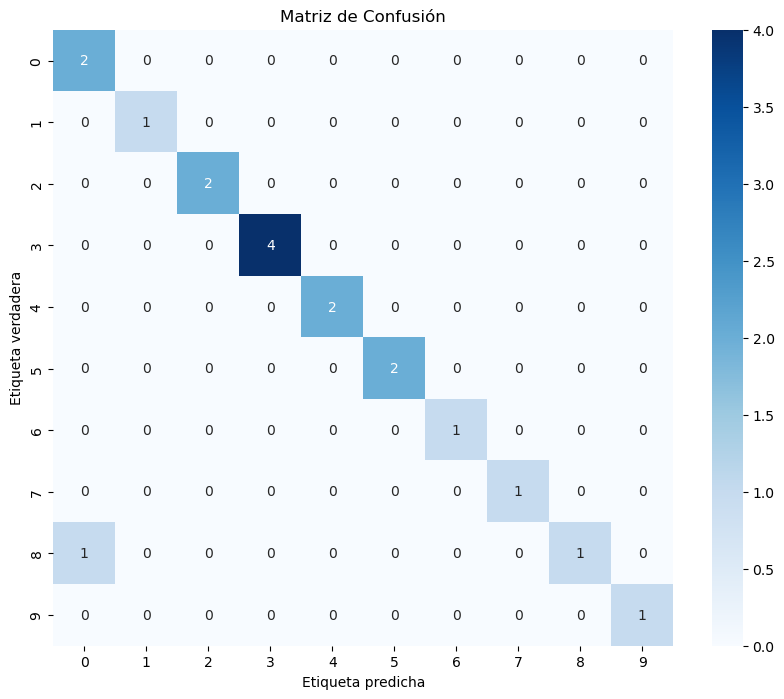

In [187]:
# Evaluar el modelo
print("Reporte:")
print(classification_report(true_labels, predicted_classes))

conf_matrix = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Etiqueta predicha')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión')
plt.show()

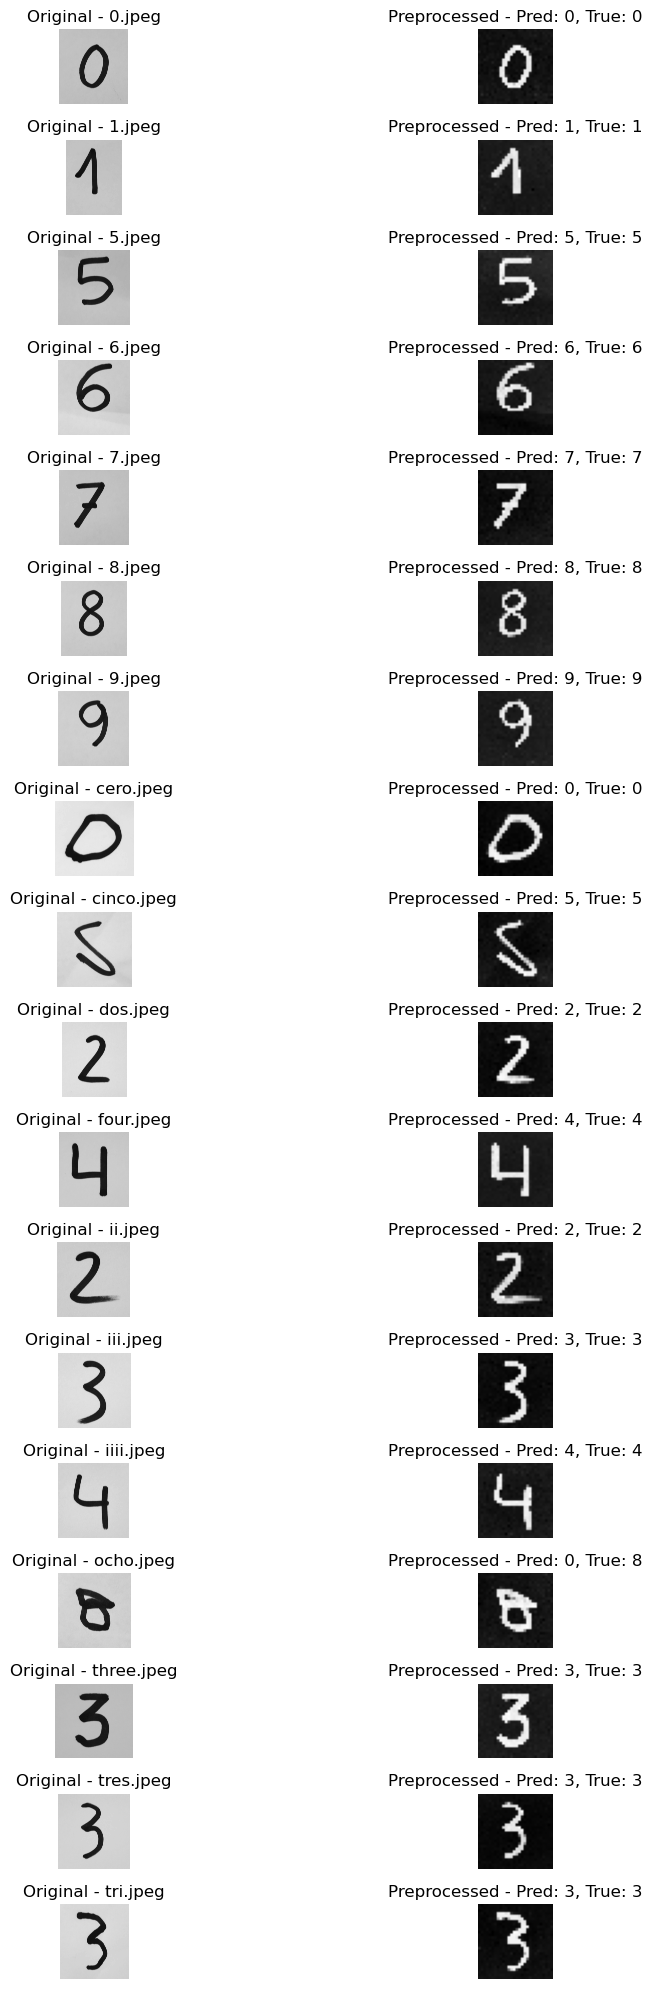

In [188]:
# Mostrar las imágenes preprocesadas junto con las predicciones
fig, axes = plt.subplots(len(image_files), 2, figsize=(10, 20))
for i, img_filename in enumerate(image_files):
    img_path = os.path.join(folder_path, img_filename)
    
    # Mostrar la imagen original
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    axes[i, 0].imshow(original_img, cmap='gray')
    axes[i, 0].set_title(f'Original - {img_filename}')
    axes[i, 0].axis('off')

    # Mostrar la imagen preprocesada
    preprocessed_img = preprocessed_images[i].reshape(28, 28)
    axes[i, 1].imshow(preprocessed_img, cmap='gray')
    axes[i, 1].set_title(f'Preprocessed - Pred: {predicted_classes[i]}, True: {true_labels[i]}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# CONCLUSIONES